In [ ]:
from fastai.vision import *

Create directory on google drive for this project

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/lesson2/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
path = Path(base_dir)

In [4]:
path

PosixPath('/content/gdrive/My Drive/fastai-v3/lesson2')

In [5]:
image_path = get_image_files(path/'data',recurse=True); image_path[:2]

[PosixPath('/content/gdrive/My Drive/fastai-v3/lesson2/data/n02085620-Chihuahua/n02085620_11948.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/lesson2/data/n02085620-Chihuahua/n02085620_12718.jpg')]

In [ ]:

np.random.seed(42)
pat = r"/n\d+-(\D+)/n\d+_\d+\.jpg$"
data = ImageDataBunch.from_name_re(path, image_path, pat=pat, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.c

120

There are 120 breeds of dogs in this dataset

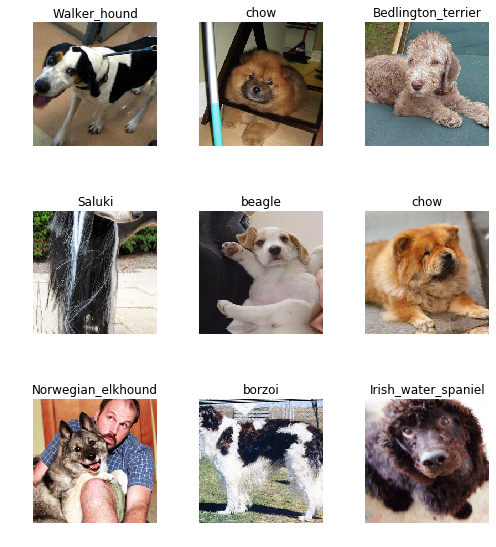

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.c, len(data.train_ds), len(data.valid_ds)

(120, 16464, 4116)

**Train model**

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.554752,0.738614,0.210641,54:07
1,0.879086,0.554181,0.173469,04:17
2,0.706240,0.494503,0.159378,04:17
3,0.588594,0.465782,0.146259,04:18
4,0.492794,0.449858,0.142614,04:15


In [ ]:
dest = path/'models'
dest.mkdir(parents=True, exist_ok=True)
learn.save(path/'models/stage-1')

In [ ]:
learn.load(path/'models/stage-1');

In [ ]:
learn.unfreeze()


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


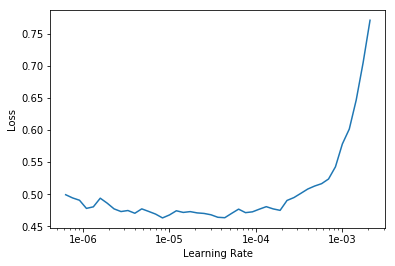

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.468605,0.443774,0.141642,16:42
1,0.478834,0.447278,0.141156,04:26
2,0.430884,0.440996,0.138970,04:23
3,0.410543,0.442462,0.137269,04:23
4,0.382180,0.435586,0.137755,04:24
5,0.350025,0.436142,0.138727,04:23
6,0.346268,0.433269,0.135569,04:23
7,0.350523,0.433884,0.137026,04:23


In [ ]:
learn.save(path/'models/stage-2')

**Interpretation**

In [ ]:
learn.load(path/'models/stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

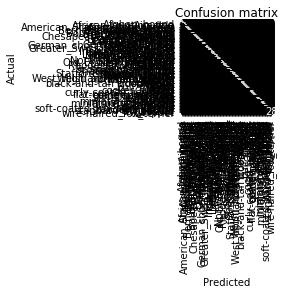

In [ ]:
interp.plot_confusion_matrix()


In [ ]:
interp.most_confused(min_val=5)

[('English_foxhound', 'Walker_hound', 12),
 ('Cardigan', 'Pembroke', 10),
 ('Eskimo_dog', 'Siberian_husky', 10),
 ('malamute', 'Siberian_husky', 10),
 ('collie', 'Border_collie', 9),
 ('American_Staffordshire_terrier', 'Staffordshire_bullterrier', 8),
 ('miniature_poodle', 'toy_poodle', 8),
 ('Lhasa', 'Shih-Tzu', 7),
 ('Siberian_husky', 'Eskimo_dog', 7),
 ('Staffordshire_bullterrier', 'American_Staffordshire_terrier', 6),
 ('collie', 'Shetland_sheepdog', 6),
 ('Appenzeller', 'EntleBucher', 5),
 ('Appenzeller', 'Greater_Swiss_Mountain_dog', 5),
 ('Irish_wolfhound', 'Scottish_deerhound', 5),
 ('Norfolk_terrier', 'Norwich_terrier', 5),
 ('silky_terrier', 'Australian_terrier', 5),
 ('standard_poodle', 'Irish_water_spaniel', 5),
 ('standard_poodle', 'miniature_poodle', 5)]

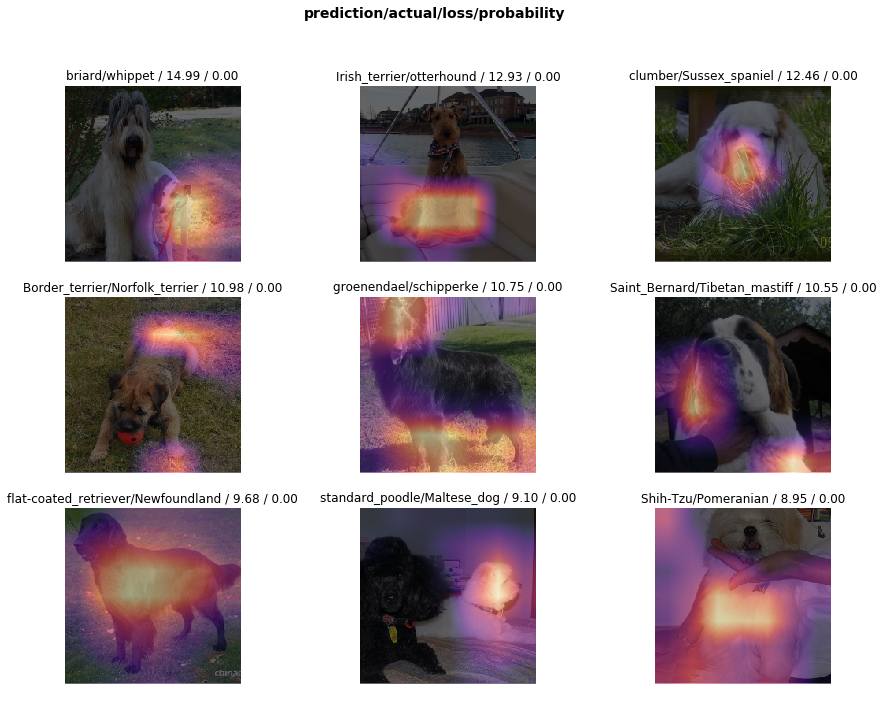

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

**RESNET50**

In [ ]:
np.random.seed(42)
pat = r"/n\d+-(\D+)/n\d+_\d+\.jpg$"
data = ImageDataBunch.from_name_re(path, image_path, pat=pat, ds_tfms=get_transforms(),bs=32, size=299, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn2 = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn2.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.891036,0.530385,0.169825,18:15
1,0.758907,0.490994,0.151361,06:30
2,0.590477,0.390512,0.124636,06:26
3,0.446910,0.364209,0.112002,06:27
4,0.337165,0.341278,0.105442,06:22


In [ ]:
dest = path/'models'
dest.mkdir(parents=True, exist_ok=True)
learn2.save(path/'models/stage-1_resnet50')

In [ ]:
learn2.load(path/'models/stage-1_resnet50');

In [ ]:
learn2.unfreeze()


In [ ]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


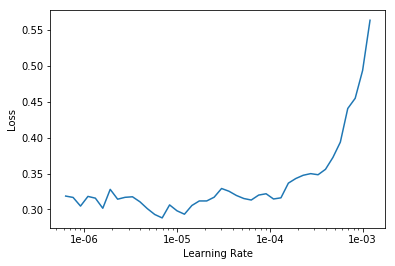

In [ ]:
learn2.recorder.plot()

In [ ]:
learn2.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.336076,0.359350,0.113460,06:38
1,0.326527,0.346963,0.107872,06:39


In [ ]:
dest = path/'models'
dest.mkdir(parents=True, exist_ok=True)
learn2.save(path/'models/stage-2_resnet50')

In [ ]:
learn2.load(path/'models/stage-1_resnet50');

In [ ]:
learn2.export(file = 'models/export.pkl')

## Putting your model in production

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
learn2 = load_learner(path/'models')

In [8]:
path

PosixPath('/content/gdrive/My Drive/fastai-v3/lesson2')

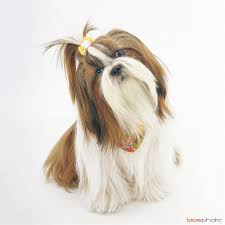

In [9]:
img = open_image(path/'test/shitzu.jpg')
img

In [ ]:
pred_class,pred_idx,outputs = learn2.predict(img)

In [ ]:
df = pd.DataFrame(list(zip(learn2.data.classes, outputs.tolist())), 
               columns =['Name', 'val'])

In [12]:
df.sort_values('val',ascending=False).head()

,Name,val
38,Japanese_spaniel,0.583610
63,Shih-Tzu,0.237358
107,papillon,0.056670
68,Tibetan_terrier,0.048249
51,Pekinese,0.023171


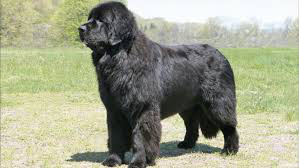

In [13]:
img = open_image(path/'test/terre-neuve.jpg')
img

In [ ]:
pred_class,pred_idx,outputs = learn2.predict(img)

In [ ]:
df = pd.DataFrame(list(zip(learn2.data.classes, outputs.tolist())), 
               columns =['Name', 'val'])

In [16]:
df.sort_values('val',ascending=False).head()

,Name,val
46,Newfoundland,0.997791
67,Tibetan_mastiff,0.001824
42,Leonberg,0.000307
12,Bouvier_des_Flandres,0.000030
30,Great_Pyrenees,0.000014
